In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 999
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

In [9]:
train = pd.read_csv("mertrain.csv")
test = pd.read_csv("mertest.csv")

# process columns, apply LabelEncoder to categorical features
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder() 
        lbl.fit(list(train[c].values) + list(test[c].values)) 
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

# shape        
print('Shape train: {}\nShape test: {}'.format(train.shape, test.shape))

Shape train: (4209, 378)
Shape test: (4209, 377)


In [10]:
y = train['y'].values
y_mean = np.mean(y)
id_test = test['ID'].values
X = train.drop(['y'], axis=1).values
X_test= test.values

In [16]:
num_columns=X.shape[1]
num_columns

377

In [17]:
vifs=[variance_inflation_factor(X, i) for i in range(0, num_columns)]

C:\Users\chino\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\chino\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [18]:
from pandas import DataFrame
vif_df=DataFrame(vifs, index=train.drop(['y'], axis=1).columns, columns=['VIF'])
vif_df=vif_df.replace([np.inf, -np.inf], np.nan).dropna(how='all')
vif_df=vif_df.sort_values(ascending=False, by='VIF')


In [19]:
best_vif=[]
for i in list(vif_df.values):
    if i>=10:
        best_vif.append(i)

In [20]:
sig_vals=np.array(vif_df.index)
sig_vals

array(['X178', 'X362', 'X331', 'X49', 'X238', 'X129', 'X352', 'X179',
       'X215', 'X161', 'X103', 'X329', 'X328', 'X356', 'X246', 'X85',
       'X45', 'X367', 'X321', 'X256', 'X191', 'X358', 'X343', 'X355',
       'X150', 'X43', 'X312', 'X272', 'X2', 'X219', 'X57', 'X241', 'X234',
       'X197', 'X159', 'X65', 'X349', 'X223', 'X325', 'X87', 'X224',
       'X182', 'X100', 'X1', 'X114', 'X135', 'X357', 'X275', 'X294',
       'X361', 'X287', 'X148', 'X221', 'X327', 'X300', 'X350', 'X211',
       'X75', 'X78', 'X116', 'X69', 'X27', 'X47', 'X274', 'X81', 'X273',
       'X267', 'X351', 'X163', 'X70', 'X218', 'X68', 'X220', 'X50', 'X322',
       'X354', 'X3', 'X366', 'X51', 'X55', 'X0', 'X64', 'X210', 'X46',
       'X106', 'ID', 'X56', 'X82', 'X318', 'X5', 'X252', 'X153', 'X359',
       'X225', 'X384', 'X301', 'X212', 'X323', 'X79', 'X91', 'X231',
       'X206', 'X353', 'X151', 'X383', 'X141', 'X73', 'X38', 'X192',
       'X124', 'X6', 'X292', 'X8', 'X270', 'X291', 'X319', 'X104', 'X288',


In [21]:
vif_df_best=vif_df[vif_df.VIF>=10]
vif_best_index=vif_df_best.index

In [22]:
train_vif=train.drop(vif_best_index[0:34], axis=1)
test_vif=test.drop(vif_best_index[0:34], axis=1)

In [23]:
y = train_vif['y'].values
y_mean = np.mean(y)
id_test = test_vif['ID'].values
X = train_vif.drop(['y'], axis=1).values
X_test= test_vif.values

In [24]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=10, shuffle=True, random_state=0)
kf.get_n_splits(X)

10

In [25]:
for train_index, test_index in kf.split(X):
    X_train, y_train=X[train_index], y[train_index]
    X_valid, y_valid=X[test_index], y[test_index]

In [28]:
forest = RandomForestRegressor(n_estimators=500, random_state=0, max_depth=5, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [32]:
print("R^2 valid: {: }".format(r2_score(y_valid, forest.predict(X_valid))))
print("R^2 train: {: }".format(r2_score(y_train, forest.predict(X_train))))

R^2 valid:  0.6000896203872931
R^2 train:  0.6065572768266798


In [47]:
train_vif2=train.drop(vif_best_index[0:27], axis=1)
test_vif2=test.drop(vif_best_index[0:27], axis=1)

In [48]:
y = train_vif['y'].values
y_mean = np.mean(y)
id_test = test_vif['ID'].values
X2 = train_vif2.drop(['y'], axis=1).values
X_test2= test_vif2.values

In [49]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=10, shuffle=True, random_state=0)
kf.get_n_splits(X2)

10

In [50]:
for train_index, test_index in kf.split(X):
    X_train2, y_train2=X[train_index], y[train_index]
    X_valid2, y_valid2=X[test_index], y[test_index]

In [65]:
X[3]

array([ 9, 24, 21, 38,  5,  3, 30, 11,  4,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  0,  1,  0,  0,  0,  1,
        0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,
        0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,
        1,  0,  1,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  1,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,
        0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,
        0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,
        1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,
        1,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  1,  0

In [51]:
import xgboost as xgb
xgb_params={
    'gamma': 1.0,
    'eta': 0.01,
    'max_depth': 3,
    'subsample':1.0,
    'objective' : 'reg:linear',
    'eval_metric': 'rmse',
    'base_score' : y_mean,
    'silent': 1,
    'lambda': 1,
    'alpha' : 0,
    'n_trees': 500
   }

# form DMatrices for Xgboost training
dtrain = xgb.DMatrix(X_train2, y_train2)
dvalid=xgb.DMatrix(X_valid2, y_valid2)
dtest = xgb.DMatrix(X_test2)

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=500, # increase to have better results (~700)
                   early_stopping_rounds=50,
                   verbose_eval=50, 
                   show_stdv=False
                  )

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

# train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

[0]	train-rmse:12.5797	test-rmse:12.5798
[50]	train-rmse:10.0884	test-rmse:10.133
[100]	train-rmse:8.98399	test-rmse:9.06199
[150]	train-rmse:8.5254	test-rmse:8.6303
[200]	train-rmse:8.31997	test-rmse:8.46359
[250]	train-rmse:8.20706	test-rmse:8.3962
[300]	train-rmse:8.13271	test-rmse:8.37378
[350]	train-rmse:8.07539	test-rmse:8.36996
342


In [52]:
print("R^2 valid: {: }".format(r2_score(y_valid, model.predict(dvalid))))
print("R^2 train: {: }".format(r2_score(y_train, model.predict(dtrain))))

R^2 valid:  0.5989482777939268
R^2 train:  0.5846443462669415


In [53]:
mx_valid=0
for i in np.arange(0, 1, 0.05):
    y_pre_pred=(model.predict(dvalid)*i)+(forest.predict(X_valid)*(1.0-i))
    y_train_pred=(model.predict(dtrain)*i)+(forest.predict(X_train)*(1.0-i))
    r2_valid=r2_score(y_valid, y_pre_pred)
    r2_train=r2_score(y_train, y_train_pred)
    if r2_valid> mx_valid:
        mx_valid=r2_valid
        rate_valid=i

In [54]:
print("average rate: {:} : {:} ".format(rate_valid, 1.0-rate_valid))
print("R^2valid max: {:}".format(mx_valid))

average rate: 0.35000000000000003 : 0.6499999999999999 
R^2valid max: 0.6006486751623243


In [55]:
pist_valid=[]
pist_train=[]
for i in np.arange(0,1, 0.05):
    y_pre_pred=model.predict(dvalid)*i + forest.predict(X_valid)*(1.0-i)
    y_train_pred=(model.predict(dtrain)*i)+( forest.predict(X_train)*(1.0-i))
    r2_valid=r2_score(y_valid, y_pre_pred)
    r2_train=r2_score(y_train, y_train_pred)
    pist_valid.append(r2_valid)
    pist_train.append(r2_train)

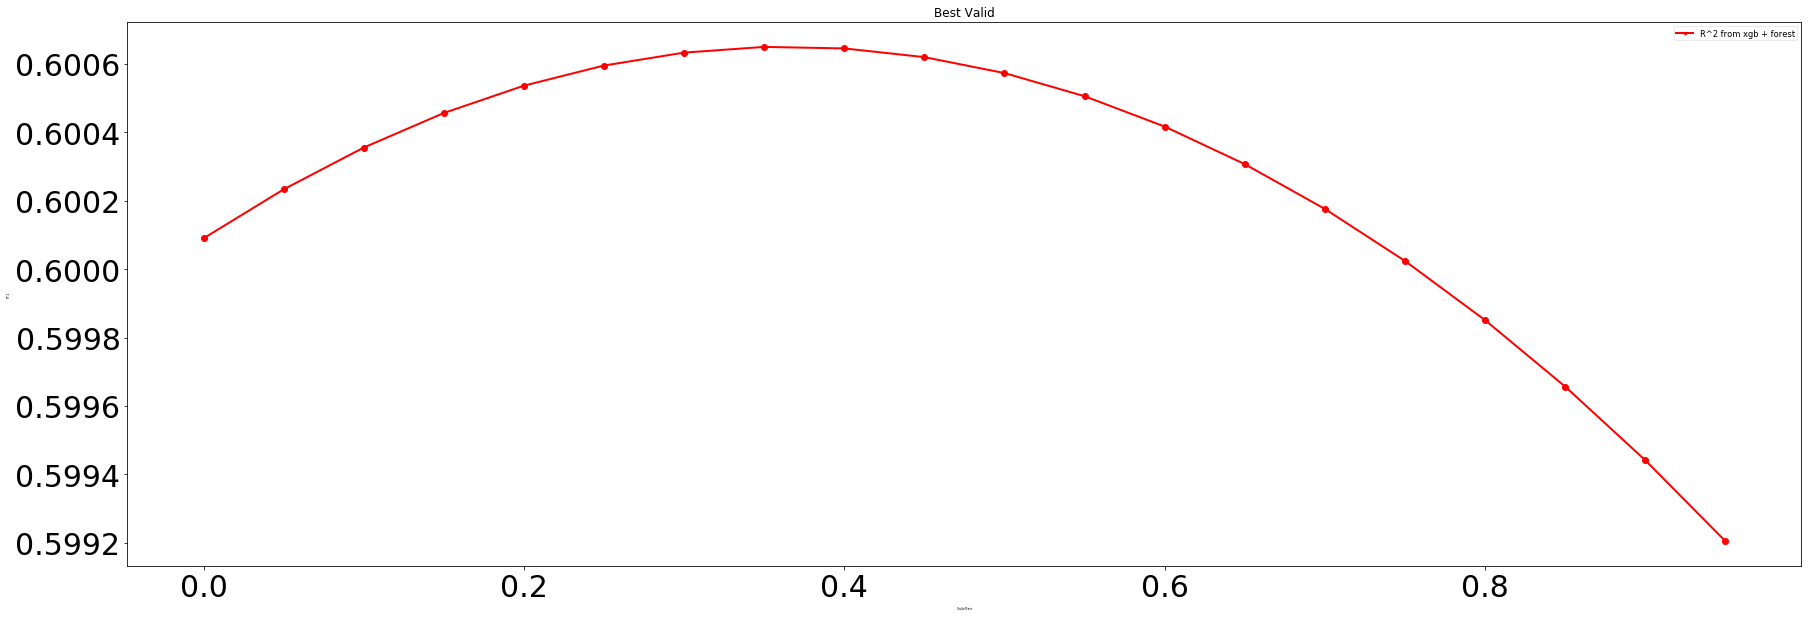

In [56]:
ig = plt.figure(figsize=(30,10))
plt.plot(np.arange(0,1,0.05), pist_valid, 'ro-', linewidth=2)
plt.title('Best Valid')
plt.xlabel('Valid Rate',fontsize=3)
plt.ylabel('R^2',fontsize=3)
plt.tick_params(labelsize=30)
leg = plt.legend(['R^2 from xgb + forest'], loc='best', borderpad=0.3,
                 shadow=False, prop= matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.draggable(state=True)
plt.show()

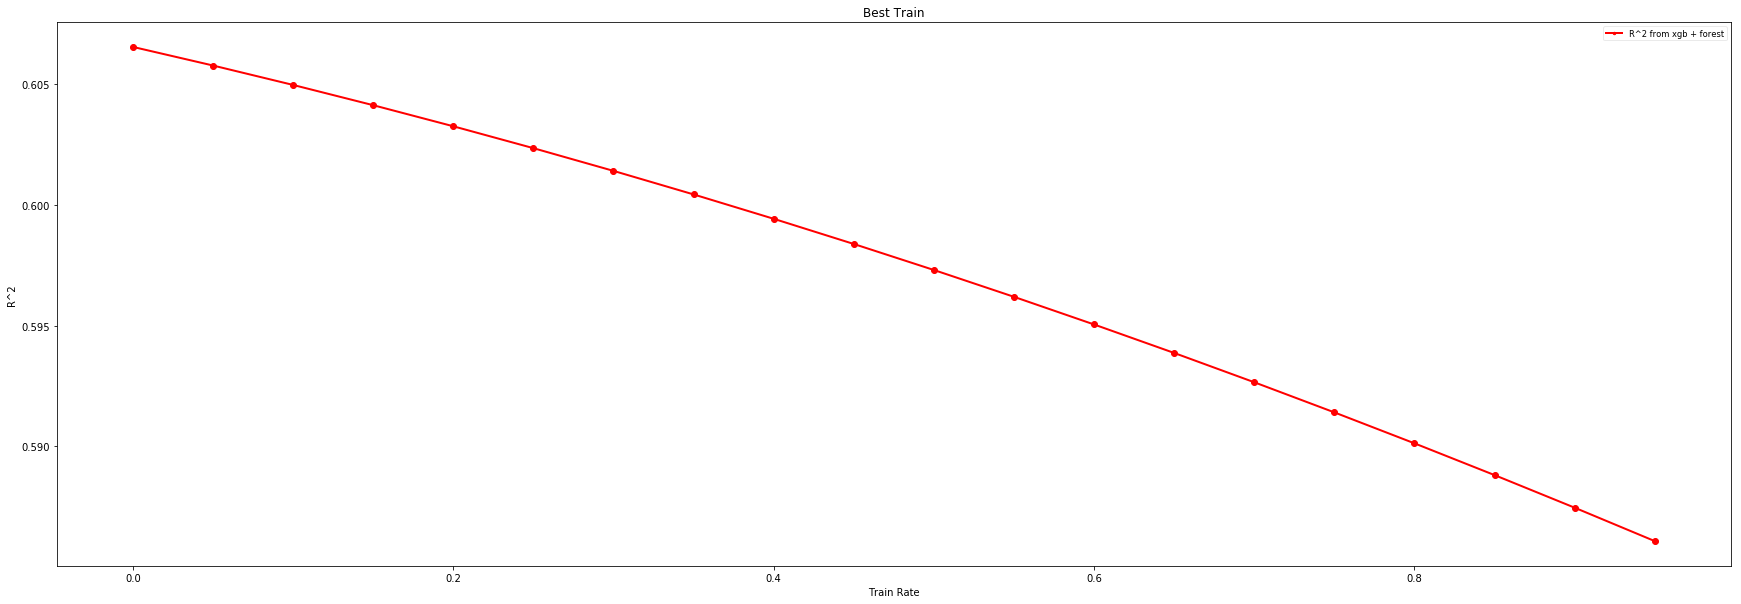

In [57]:
ig = plt.figure(figsize=(30,10))
plt.plot(np.arange(0,1,0.05), pist_train, 'ro-', linewidth=2)
plt.title('Best Train')
plt.xlabel('Train Rate')
plt.ylabel('R^2')
leg = plt.legend(['R^2 from xgb + forest'], loc='best', borderpad=0.3,
                 shadow=False, prop= matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.draggable(state=True)
plt.show()

In [58]:
y_pred_xgb = model.predict(dtest)
y_pred_forest = forest.predict(X_test)

In [59]:
y_pred = y_pred_xgb*0.35+y_pred_forest*0.65

In [60]:
sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = y_pred
sub.to_csv('average-xgb35+forest65-best.csv', index=False)